# CSE 311A Programming Assignment 2 - David Frankel (466602)

Grading Note: Due to the large number of figures and otherwise supporting data in this document, I have typed out my responses to the questions here and added a link to their relevant output cells.

## Question 1

Part 1: [Program run output, generated plots, and other data](#Question-1-Implementation).

Part 2: Looking at the plots, I noticed the following trends:

- Initially, players of type AC are at a disadvantage and die due to their significant losses in games against type AD, but they are replaced with types T4T and G (which perform well in cooperating with each other and AC, and can manage losses against AD).

- Then, as the game progresses, players of the type AD are driven to extinction. This is because all of the other player types get a large advantage of constant cooperation (+3) when playing against each other. Ignoring the first turns with TFT and G, AD gets a small payoff (+1) with these players. Despite the large payoff AD gets from games with AC (+5), this is not enough to recover this relative loss because AC's population is small from deaths in the early generations.

- The game stagnates after the extinction of AD players, because the only actions left are cooperation (AC, G, and T4T will always cooperate with each other). At this point, there is only a random replacement of "top" performers, which is just a random selection of all players.

## Question 2

Part 1: [Program run output, generated plots, and other data](#Question-2-Implementation).

Part 2: Looking at the plots, I noticed the following trends for each distribution:

First Distribution: One Grudger player, one Always Cooperate player, and n-2 Tit-for-Tat players

- In this example, there is a stagnation of player populations and payoffs from the first generation onwards, and a small probabilistic chance of extinction for any of the player types. As the anaylsis in Question 1 reveals, in a game of T4T, G, and AC players, the result is games where every player always cooperates. As a result, the only chance of extinction comes from the probability that the last surviving players of a type end up in the bottom p% (which is meaningless since they all have the same payoffs).

Second Distribution: One Grudger player, one Always Cooperate player, and n-2 Always Defect players

- Due to their small numbers, the G and AC players go extinct after the first generation. Unlike in question 1, there aren't enough cooperating-type players to balance out the penaly from AD players doing extremely well against AC players and somewhat well against G players. After this, AD rules supereme forever.

Third Distribution: Mostly AD, with some G, and very little AC and tiny amount of T4T

- Initially, AC dies and is replaced with AD

- Once 

## Question 3

Part 1: [Program run output, generated plots, and other data](#Question-3-Implementation).

Part 2: Looking at the plots, I noticed the following trends for each distribution:

In [1]:
import random
import copy
from itertools import islice
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# True: Cooperate, False: Defect
class Player:
    payoff = 0
    def reset(self):
        self.choice = self.og_choice
    def fullreset(self):
        self.choice = self.og_choice
        self.payoff = 0
    def update(self, opponent_choice):
        pass
    
# Tit-for-Tat (T4T) players
# Start by cooperating and play the opponent’s last action in subsequent rounds
class T4T(Player):
    og_choice = True
    choice = True # Defaults to cooperating, should change to opponent's last action
    def update(self, opponent_choice):
        self.choice = opponent_choice
        
# Grudger (G) players
# Cooperate until the opponent defects, after which it only defects
class G(Player):
    og_choice = True
    choice = True # Defaults to cooperating, should change to defection as response
    def update(self, opponent_choice):
        if not opponent_choice:
            self.choice = False
        
# Always Cooperate (AC) players
# Always cooperate
class AC(Player):
    og_choice = True
    choice = True

# Always Defect (AD) players
# Always defect
class AD(Player):
    og_choice = False
    choice = False
        

In [2]:
def simulate_generation(players, m):
    # Players needs to be an input list of already made player objects
    already_visited = 0
    for one in players:
        already_visited += 1
        for two in islice(players, already_visited, None):
            for _ in range(m):
                if one.choice and two.choice:
                    one.payoff += 3
                    two.payoff += 3
                elif not one.choice and not two.choice:
                    one.payoff += 1
                    two.payoff += 1
                elif one.choice:
                    two.payoff += 5
                elif two.choice:
                    one.payoff += 5
                else:
                    print("Never be here!")

                one_choice = one.choice
                two_choice = two.choice
                one.update(two_choice)
                two.update(one_choice)

            # Resets player state between games
            one.reset()
            two.reset()

def birth(players, m, p, k, printing=True):
    reset_global_stats()
    p = p / 100
    generation = players
    for i in range(k):
        simulate_generation(generation, m)
        if printing:
            print("Gen ", (i+1),": ", sep="", end="")
        print_stats(generation, printing)
        
        random.shuffle(generation) # Allows easy tie-breaking
        generation.sort(key=lambda x: x.payoff)
        p_num_players = int(len(generation) // (1/p))
        del generation[:p_num_players]
        new_players = []
        for new in generation[-p_num_players:]:
            new_players.append(type(new)())
        generation = generation + new_players
        for player in generation:
            player.fullreset()
        

In [3]:
stackplot_type_percentage = [[], [], [], []]
stackplot_type_total = [[], [], [], []]
multiline_type_avg = [[], [], [], []]
unknown_type_payoff_total = []

def reset_global_stats():
    # Access to globals
    global stackplot_type_percentage
    global stackplot_type_total
    global multiline_type_avg
    global unknown_type_payoff_total
    stackplot_type_percentage = [[], [], [], []]
    stackplot_type_total = [[], [], [], []]
    multiline_type_avg = [[], [], [], []]
    unknown_type_payoff_total = []

def print_stats(players, printing):
    # Access to globals
    global stackplot_type_percentage
    global stackplot_type_total
    global multiline_type_avg
    global unknown_type_payoff_total
    
    # Always in T4T, G, AC, AD order
    n = len(players)
    player_types = ['T4T', 'G', 'AC', 'AD']
    player_types_num = np.array([0, 0, 0, 0])
    player_types_payoff = np.array([0, 0, 0, 0])
    for player in players:
        if type(player) is T4T:
            player_types_num[0] += 1
            player_types_payoff[0] += player.payoff
        elif type(player) is G:
            player_types_num[1] += 1
            player_types_payoff[1] += player.payoff
        elif type(player) is AC:
            player_types_num[2] += 1
            player_types_payoff[2] += player.payoff
        elif type(player) is AD:
            player_types_num[3] += 1
            player_types_payoff[3] += player.payoff
        else:
            print("Nope! Not here")
    
    player_types_num = (player_types_num * 100) // n
    
    if printing:
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_num[i], "%  ", sep="", end="")
        print()


        print("       ", end="")
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_payoff[i], "  ", sep="", end="")
        print("Total: ", sum(player_types_payoff), end="")
        print()
        print("       ", end="")
    
    for i in range(4):
        stackplot_type_percentage[i].append(player_types_num[i])
        stackplot_type_total[i].append(player_types_payoff[i])
    unknown_type_payoff_total.append(sum(player_types_payoff))
    
    
    with np.errstate(invalid='ignore', divide='ignore'):
        # player_types_payoff = np.nan_to_num(player_types_payoff / player_types_num)
        # Corrects graphing issue
        player_types_payoff = (player_types_payoff / player_types_num)

    for i in range(4):
        multiline_type_avg[i].append(player_types_payoff[i])
        
    if printing:
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_payoff[i], "  ", sep="", end="")
        print()


In [4]:
def gen_n_player_evenly(n):
    players = []
    for _ in range(n // 4):
        players.append(T4T())
        players.append(G())
        players.append(AC())
        players.append(AD())
    return players
    

In [39]:
def plot_globals():    
    # Plot percentage of population by type.
    labels = ['T4T', 'G', 'AC', 'AD']
    
    _, ax = plt.subplots()
    x_axis_vals = np.arange(1, len(stackplot_type_percentage[0])+1)
    x_axis_ticks = np.arange(1, len(stackplot_type_percentage[0])+1, step=(len(stackplot_type_percentage[0])+1) // 10)
    ax.stackplot(x_axis_vals, stackplot_type_percentage, labels=labels)
    ax.legend(loc='upper right')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Percentage')
    ax.set_title('Population by Type')
    ax.set_xticks(x_axis_ticks)
    plt.show()
    #     plt.clf()
    
    _, ax = plt.subplots()
    ax.stackplot(np.arange(1, len(stackplot_type_percentage[0])+1), stackplot_type_total, labels=labels)
    ax.legend(loc='upper right')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Payoff')
    ax.set_title('Payoff by Type and Total Payoff')
    ax.set_xticks(x_axis_ticks)
    plt.plot()
    plt.show()
    
    # plt.clf()
    
    _, ax = plt.subplots()
    ax.set_title("Average Payoff by Type")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Average Payoff")
    ax.set_xticks(x_axis_ticks)
    line_type = ['-', '--', ':', '-.']
    for i in range(len(multiline_type_avg)):
        plt.plot(multiline_type_avg[i], line_type[i], label=labels[i])
    ax.legend(loc="upper right")
    plt.show()



## Question 1 Implementation
[Back to top](#Question-1)

In [33]:
# Running the program with specified parameters

n = 100 # Starting num of players
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations
players = gen_n_player_evenly(n)
birth(players, m, p, k)

Gen 1: T4T: 25%  G: 25%  AC: 25%  AD: 25%  
       T4T: 30250  G: 30250  AC: 27750  AD: 29875  Total:  118125
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1195.0  
Gen 2: T4T: 27%  G: 28%  AC: 20%  AD: 25%  
       T4T: 32670  G: 33880  AC: 22200  AD: 27875  Total:  116625
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1115.0  
Gen 3: T4T: 30%  G: 30%  AC: 15%  AD: 25%  
       T4T: 36300  G: 36300  AC: 16650  AD: 25875  Total:  115125
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1035.0  
Gen 4: T4T: 32%  G: 33%  AC: 15%  AD: 20%  
       T4T: 40480  G: 41745  AC: 17775  AD: 21100  Total:  121100
       T4T: 1265.0  G: 1265.0  AC: 1185.0  AD: 1055.0  
Gen 5: T4T: 35%  G: 35%  AC: 15%  AD: 15%  
       T4T: 46200  G: 46200  AC: 18900  AD: 16125  Total:  127425
       T4T: 1320.0  G: 1320.0  AC: 1260.0  AD: 1075.0  
Gen 6: T4T: 38%  G: 37%  AC: 15%  AD: 10%  
       T4T: 52250  G: 50875  AC: 20025  AD: 10950  Total:  134100
       T4T: 1375.0  G: 1375.0  AC: 1335.0  AD: 1095.0  
Gen 

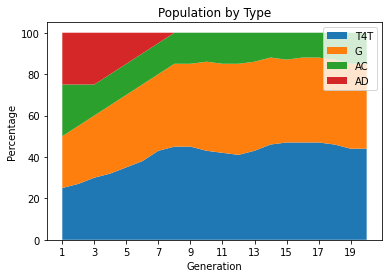

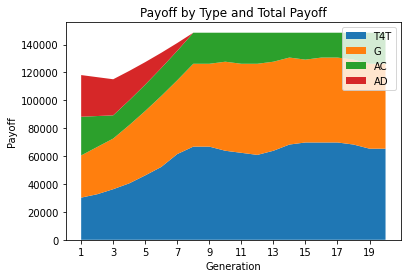

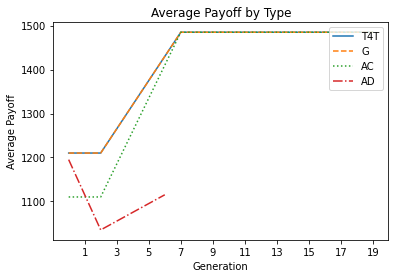

In [40]:
# Generating plots

plot_globals()

## Question 2 Implementation
[Back to top](#Question-2)

### First Distribution: One Grudger player, one Always Cooperate player, and n-2 Tit-for-Tat players

Gen 1: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 2: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 3: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 4: T4T: 97%  G: 2%  AC: 1%  AD: 0%  
       T4T: 144045  G: 2970  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 5: T4T: 97%  G: 2%  AC: 1%  AD: 0%  
       T4T: 144045  G: 2970  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 6: T4T: 97%  G: 2%  AC: 1%  AD: 0%  
       T4T: 144045  G: 2970  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 7: T4T: 97%  G: 2%  AC: 1%  AD: 0%  
       T4T: 144045  G: 2970  

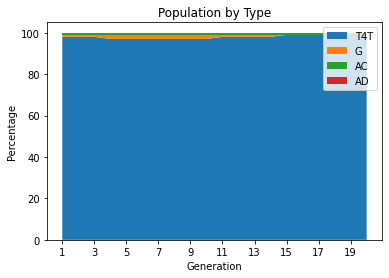

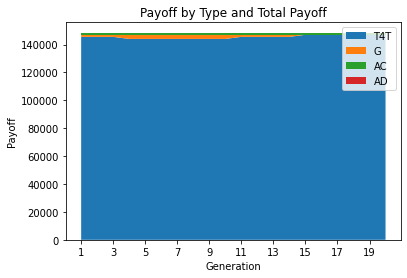

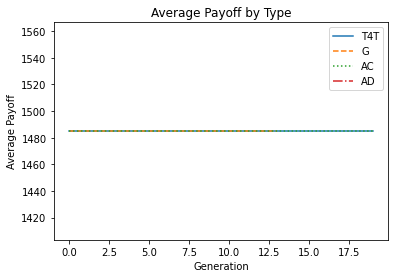

In [8]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = [G(), AC()]
for _ in range(n-len(players)):
    players.append(T4T())

birth(players, m, p, k)
plot_globals()

### Second Distribution: One Grudger player, one Always Cooperate player, and n-2 Always Defect players

Gen 1: T4T: 0%  G: 1%  AC: 1%  AD: 98%  
       T4T: 0  G: 407  AC: 15  AD: 50862  Total:  51284
       T4T: nan  G: 407.0  AC: 15.0  AD: 519.0  
Gen 2: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 3: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 4: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 5: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 6: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 7: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 8: T

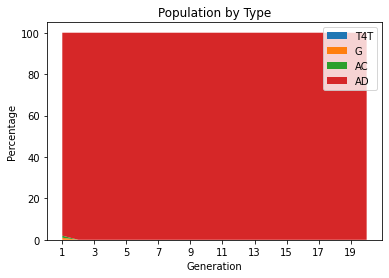

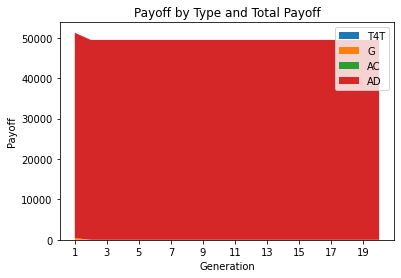

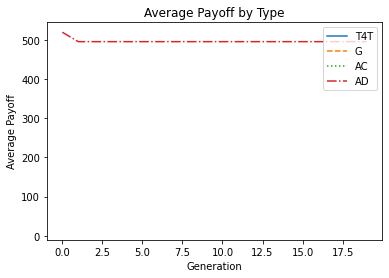

In [9]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = [G(), AC()]
for _ in range(n-len(players)):
    players.append(AD())

birth(players, m, p, k)
plot_globals()

Looking at the plots above, I noticed the following trends:

- AHHHHH

### Third Distribution: Mostly AD, with some G, and very little AC and tiny amount of T4T

Gen 1: T4T: 2%  G: 20%  AC: 8%  AD: 70%  
       T4T: 1430  G: 14300  AC: 3480  AD: 52010  Total:  71220
       T4T: 715.0  G: 715.0  AC: 435.0  AD: 743.0  
Gen 2: T4T: 2%  G: 20%  AC: 3%  AD: 75%  
       T4T: 1320  G: 13200  AC: 1080  AD: 48225  Total:  63825
       T4T: 660.0  G: 660.0  AC: 360.0  AD: 643.0  
Gen 3: T4T: 2%  G: 25%  AC: 0%  AD: 73%  
       T4T: 1364  G: 17050  AC: 0  AD: 44019  Total:  62433
       T4T: 682.0  G: 682.0  AC: nan  AD: 603.0  
Gen 4: T4T: 2%  G: 30%  AC: 0%  AD: 68%  
       T4T: 1474  G: 22110  AC: 0  AD: 42364  Total:  65948
       T4T: 737.0  G: 737.0  AC: nan  AD: 623.0  
Gen 5: T4T: 2%  G: 35%  AC: 0%  AD: 63%  
       T4T: 1584  G: 27720  AC: 0  AD: 40509  Total:  69813
       T4T: 792.0  G: 792.0  AC: nan  AD: 643.0  
Gen 6: T4T: 2%  G: 40%  AC: 0%  AD: 58%  
       T4T: 1694  G: 33880  AC: 0  AD: 38454  Total:  74028
       T4T: 847.0  G: 847.0  AC: nan  AD: 663.0  
Gen 7: T4T: 2%  G: 45%  AC: 0%  AD: 53%  
       T4T: 1804  G: 40590  AC: 0  A

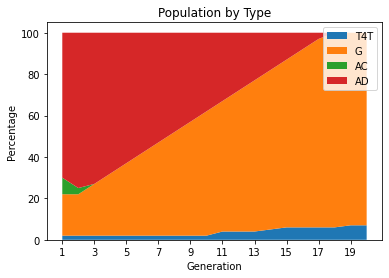

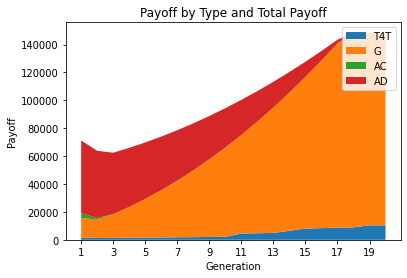

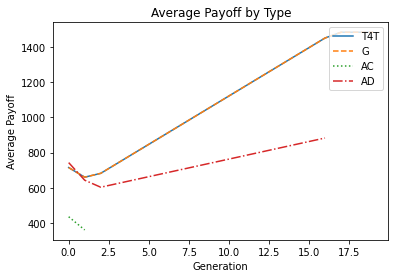

In [10]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = []
for _ in range(8):
    players.append(AC())
for _ in range(2):
    players.append(T4T())
for _ in range(70):
    players.append(AD())
for _ in range(20):
    players.append(G())

birth(players, m, p, k)
plot_globals()

Looking at the plots above, I noticed the following trends:

- AHHHHH

## Question 3 Implementation
[Back to top](#Question-3)

P-Val 1


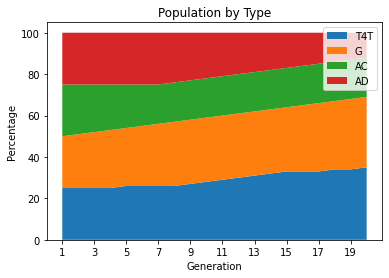

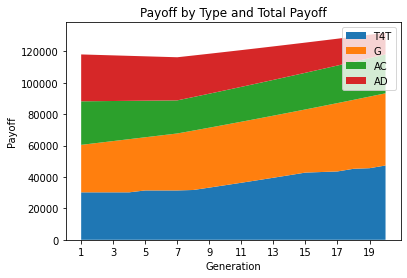

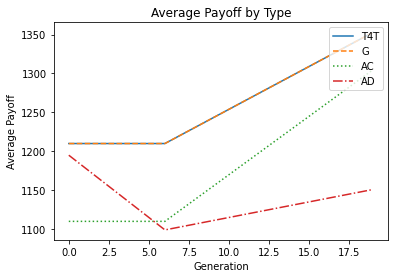

P-Val 4


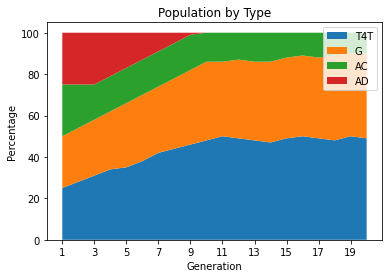

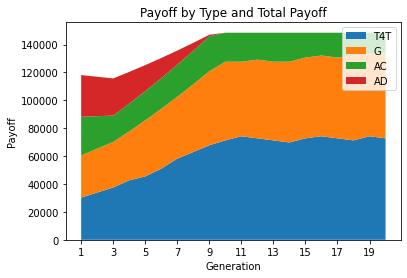

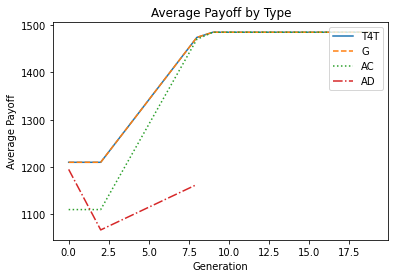

P-Val 7


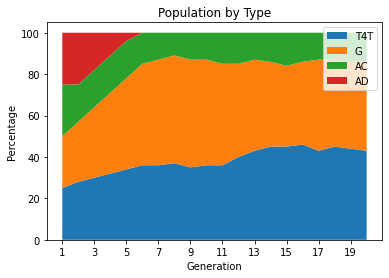

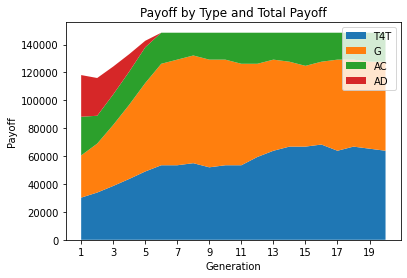

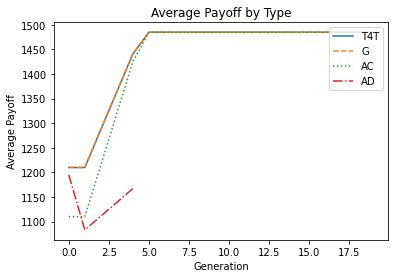

P-Val 10


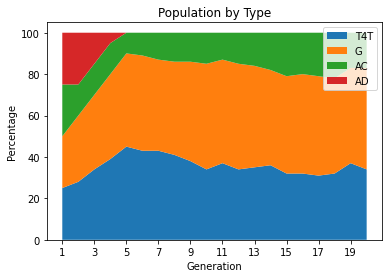

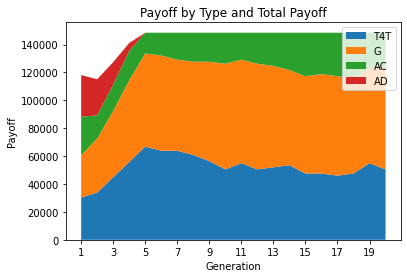

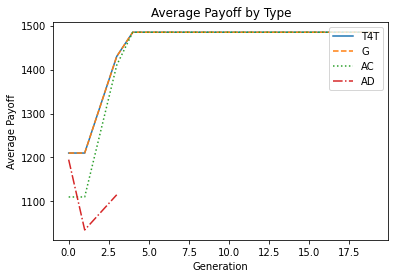

P-Val 13


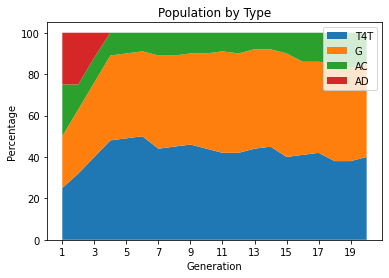

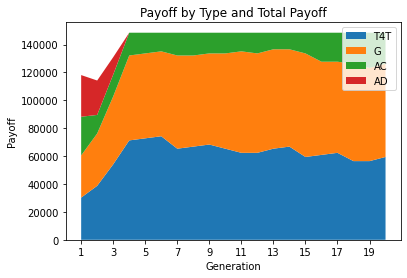

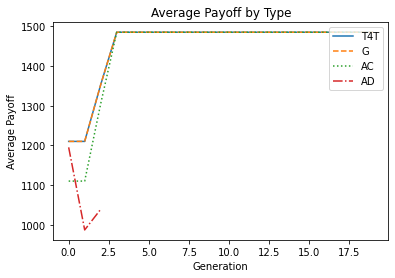

P-Val 16


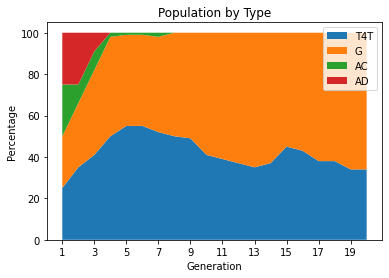

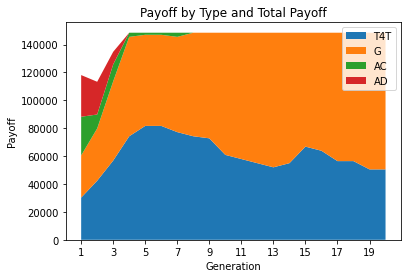

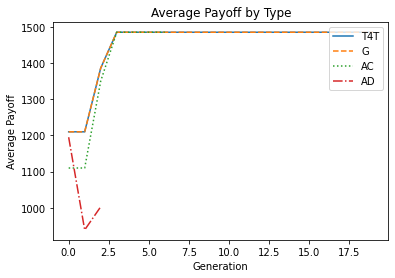

P-Val 19


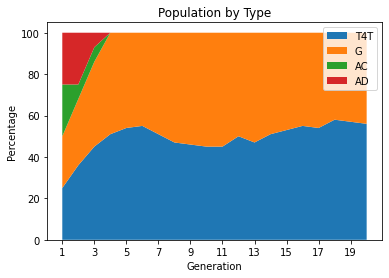

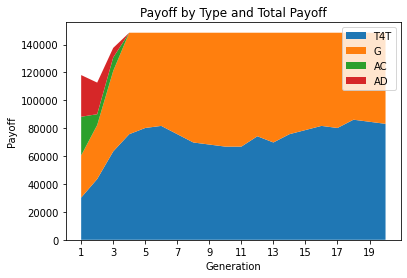

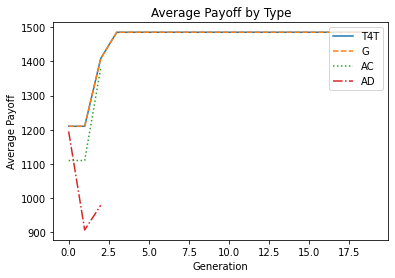

P-Val 22


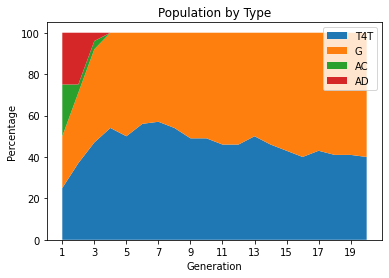

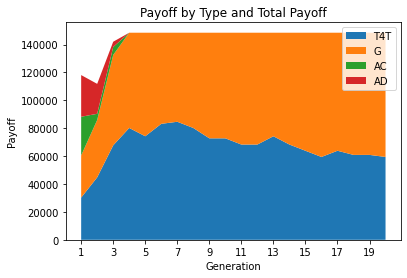

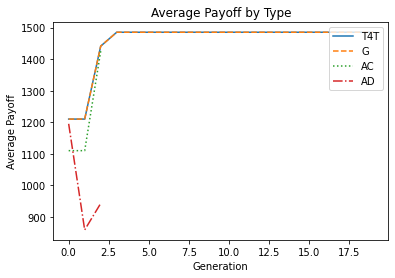

In [11]:
# Systematically varying value of p
# Running the program with specified parameters from Q1

n = 100 # Starting num of players
m = 5 # Rounds between players
p = 1 # Pruning between generations, will vary
k = 20 # Generations
for p in range(1, 25, 3):
    print("P-Val", p)
    players = gen_n_player_evenly(n)
    birth(players, m, p, k, printing=False)
    plot_globals()

JK GREEN DIES! AHH